<a href="https://colab.research.google.com/github/Lisitcyn/ML/blob/main/mnist_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import torchvision as tv
import time
import matplotlib.pyplot as plt

In [ ]:
def corr2d(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i: i + h, j: j + w] * K).sum()
    return Y

In [ ]:
X = torch.Tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
K = torch.Tensor([[0, 1], [2, 3]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [ ]:
BATCH_SIZE = 256

In [ ]:
transforms = tv.transforms.Compose([
    tv.transforms.Resize(32),
    tv.transforms.ToTensor()
])

In [ ]:
train_dataset = tv.datasets.MNIST('.',
                                  train=True,
                                  transform=transforms,
                                  download=True)

test_dataset = tv.datasets.MNIST('.',
                                 train=False,
                                 transform=transforms,
                                 download=True)

train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
train_dataset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 5)

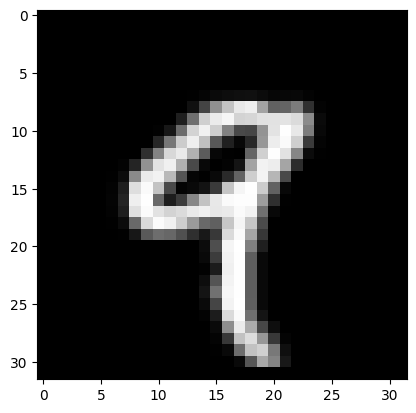

In [ ]:
plt.imshow(train_dataset[4][0].numpy().reshape(32,32), cmap='gray');

In [ ]:
class ModifiedLeNet(nn.Module):
    def __init__(self):
        super(ModifiedLeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)  # Увеличение числа фильтров
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)  # Увеличение числа фильтров
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)  # Увеличение числа фильтров
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.AvgPool2d(2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 4 * 4, 120)  # Учитываем размер выходного тензора
        self.dropout = nn.Dropout(0.5)  # Регуляризация
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.bn1(self.conv1(x))))
        x = self.pool(nn.functional.relu(self.bn2(self.conv2(x))))
        x = self.pool(nn.functional.relu(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = self.dropout(nn.functional.relu(self.fc1(x)))
        x = self.dropout(nn.functional.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#model = ModifiedLeNet().to(device)

Обучение на GPU

In [ ]:
model = model.to(device)
model = ModifiedLeNet().to(device)

In [ ]:
#for inputs, labels in DataLoader:
   # inputs, labels = inputs.to(device), labels.to(device)

In [ ]:
def train(net, train_iter, test_iter, optimizer, num_epochs, device):
    loss = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        net.train()  # Установка режима обучения

        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

        test_acc = evaluate_accuracy(test_iter, net, device)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}' \
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')


In [ ]:
lr, num_epochs = 0.001, 10  # Увеличение количества эпох для лучшего обучения
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
train(model, train_iter, test_iter, optimizer, num_epochs, device)

epoch 1, loss 0.0017, train acc 0.864, test acc 0.985, time 13.5 sec
epoch 2, loss 0.0004, train acc 0.972, test acc 0.989, time 14.1 sec
epoch 3, loss 0.0003, train acc 0.979, test acc 0.988, time 13.4 sec
epoch 4, loss 0.0003, train acc 0.983, test acc 0.989, time 13.5 sec
epoch 5, loss 0.0002, train acc 0.986, test acc 0.990, time 13.4 sec
epoch 6, loss 0.0002, train acc 0.986, test acc 0.989, time 13.4 sec
epoch 7, loss 0.0002, train acc 0.988, test acc 0.990, time 13.4 sec
epoch 8, loss 0.0002, train acc 0.989, test acc 0.992, time 13.4 sec
epoch 9, loss 0.0002, train acc 0.990, test acc 0.992, time 13.4 sec
epoch 10, loss 0.0002, train acc 0.990, test acc 0.988, time 13.4 sec
